# Project description: Taxi Orders Model

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Table of Contents

1. Data Preparation
2. Data Analysis
3. Training & Testing
4. Conclusion

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Data Preparation

First, we import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
random_state=12345

In [2]:
data = pd.read_csv("/datasets/taxi.csv", index_col = [0], parse_dates = [0])

data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


There are no missing values. However, we need to check for duplicates. To do this, we check the number of unique values  present in the datetime index. We have 26496 rows, therefore, if we have 26496 unique index values, then there are no duplicates. Anything less will indicate the presence of duplicates

In [4]:
data.index.unique().shape

(26496,)

There are no duplicates, and our data has the right data type

## Data Analysis

We will analyze trends and seasonality in different timeframes. However, we need to check if the dates and times are in chronological order. 

In [5]:
data.sort_index(inplace = True) #sorts the index in ascending order
print(data.index.is_monotonic)

True


It turns out that the order of our dataset is chronological

Next, we plot the number of orders after resampling them by an hour.

<AxesSubplot:xlabel='datetime'>

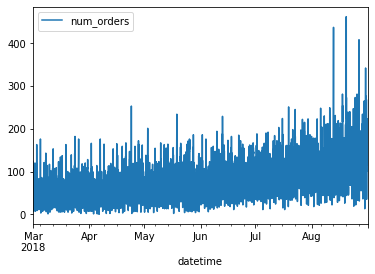

In [6]:
data_hour = data.resample('1H').sum() #resamples the data by the hour
data_hour.plot() #makes a plot of our hourly data


We have a lot of data points to look at. Therefore to analyze better, we have to decompose the data into seasonality, trend, and residuals, then make new plots

Text(0.5, 1.0, 'Residuals')

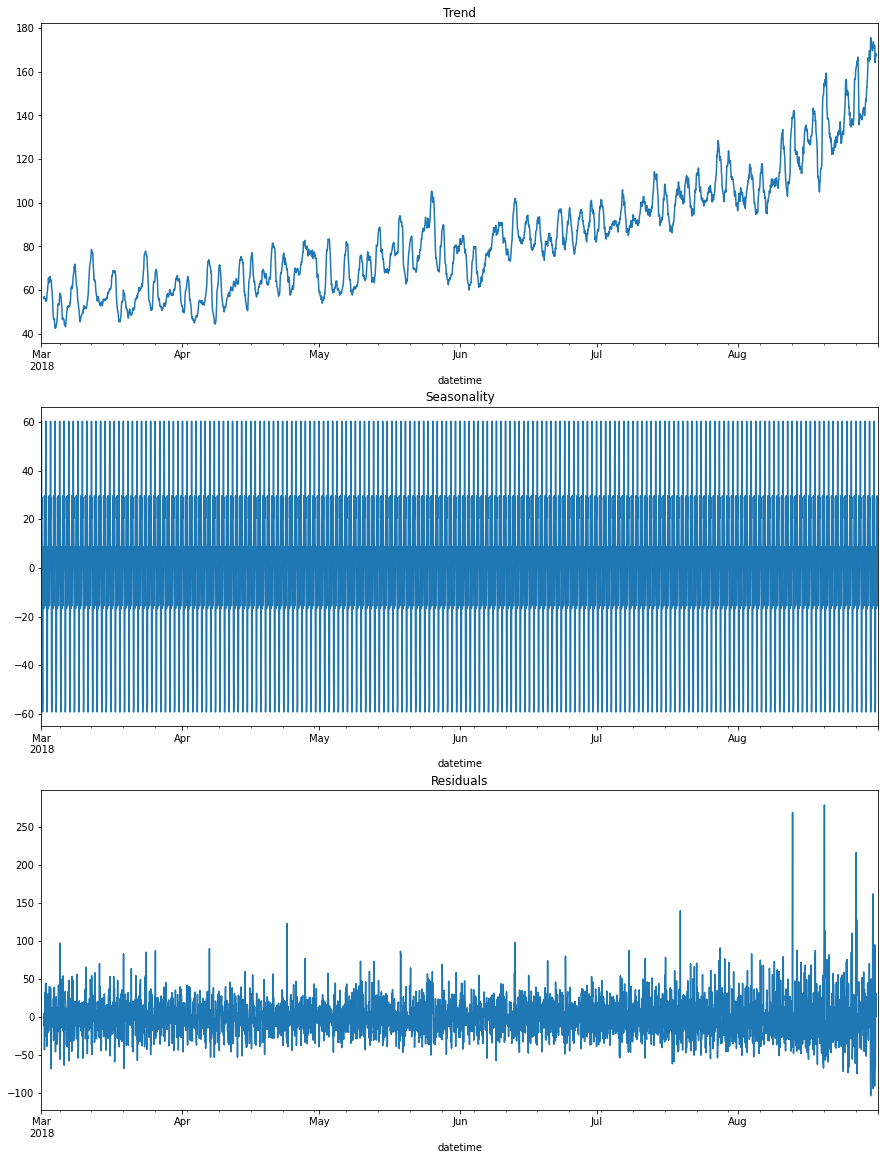

In [7]:
decomposed = seasonal_decompose(data_hour) #decomposes the data to trend, seasonality and residuals 

plt.figure(figsize = (15, 20))#creates a figure of height 20in and width 15in

#create the subplots for trend, seasonality, and residuals, gets their axes and fits them in the figure
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')

There is a continous upward trend throughout the months starting from March 2018. However, we cannot figure out seasonality for that period of time. Residuals tell us when there are unusual spikes or lows. That is still a lot of data points. 
We would try resampling our hourly data to daily data. After which we will add the rolling mean and rolling standard deviation and plot those points.

<AxesSubplot:xlabel='datetime'>

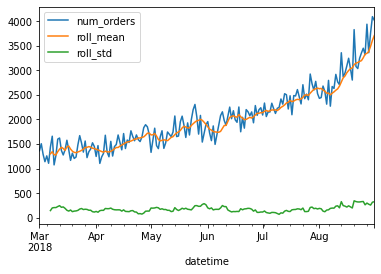

In [8]:
data_day = data_hour.resample('1D').sum() #resampling the hourly data by the day
data_day['roll_mean'] = data_day['num_orders'].rolling(7).mean()
#creating a column calculating the rolling mean with a window size of 7
data_day['roll_std'] = data_day['num_orders'].rolling(7).std()
#creating a column calculating the rolling standard deviation with a window size of 7
data_day.plot() #plots a graph for the daily data

We observe a steady increase in the mean and a quite steady standard deviation all through.

Considering the hourly data, we take a slice of the data of one of the weeks and observe the trend and seasonality. We chose August 25 to August 31 (Saturday to Friday)

Text(0.5, 1.0, 'Residuals')

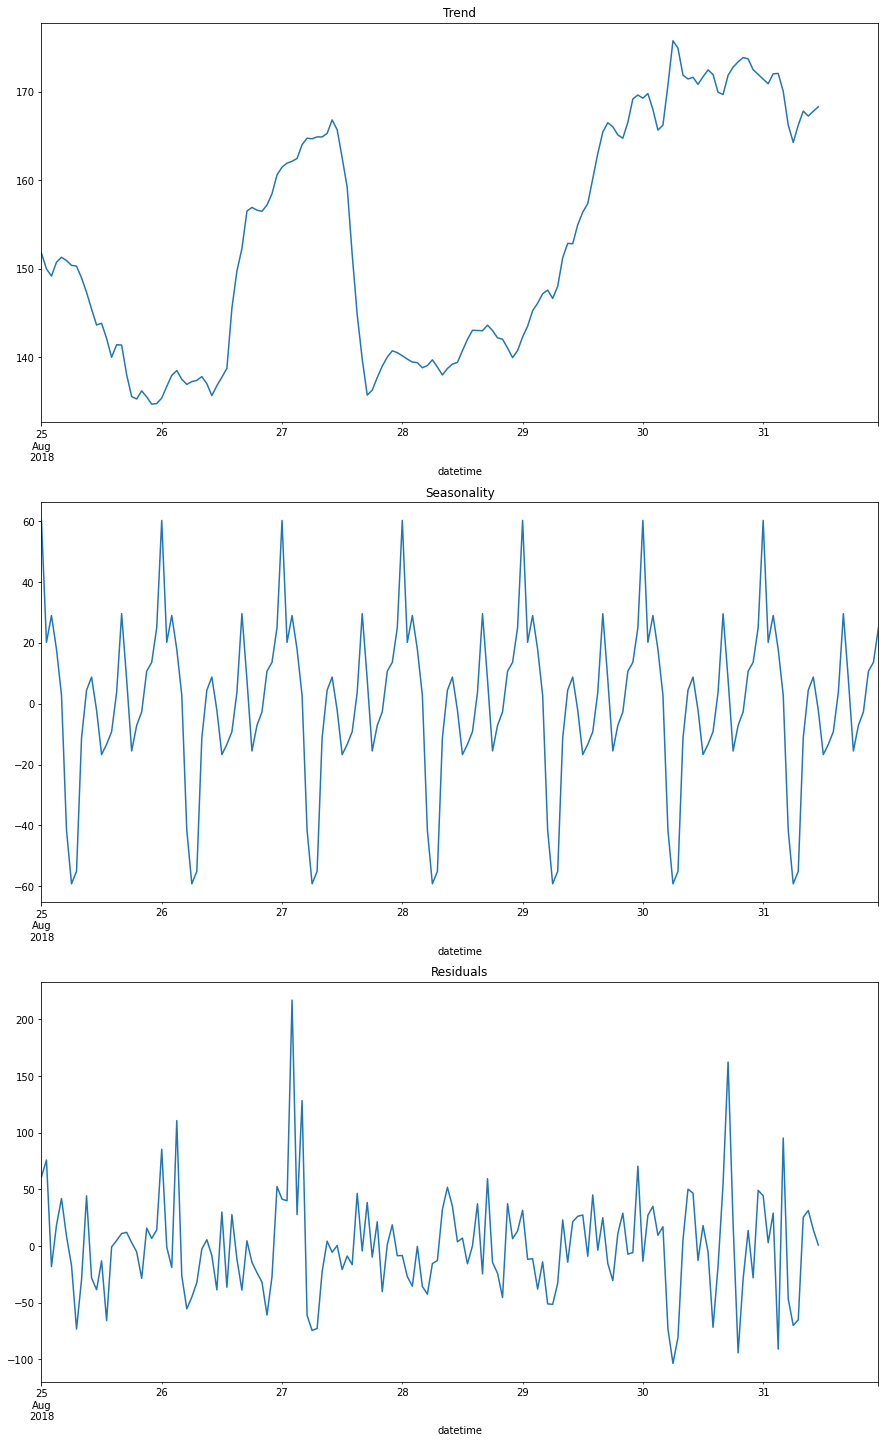

In [9]:
#decomposed = seasonal_decompose(data_hour.loc['2018-04-16':'2018-04-22',:]) #gets the week slice and decomposes it

plt.figure(figsize = (15, 25))#creates a figure with height 25in and width 15in

#create the subplots for trend, seasonality, and residuals, gets their axes and fits them in the figure
plt.subplot(311)

decomposed.trend[-168:].plot(ax=plt.gca())

#decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal[-168:].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid[-168:].plot(ax=plt.gca())
plt.title('Residuals')

From the trend, we can see that the highest number of orders came on the 30th (Thursday). From the seasonality graph, we can see the pattern followed throughout the days. Residuals show spikes in orders, the highest being on Monday morning, the 27th

Let us plot with the rolling mean and rolling standard deviation.

/tmp/ipykernel_101/460747304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_std_mean['roll_mean'] = data_std_mean['num_orders'].rolling(7).mean()
/tmp/ipykernel_101/460747304.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_std_mean['roll_std'] = data_std_mean['num_orders'].rolling(7).std()


<AxesSubplot:xlabel='datetime'>

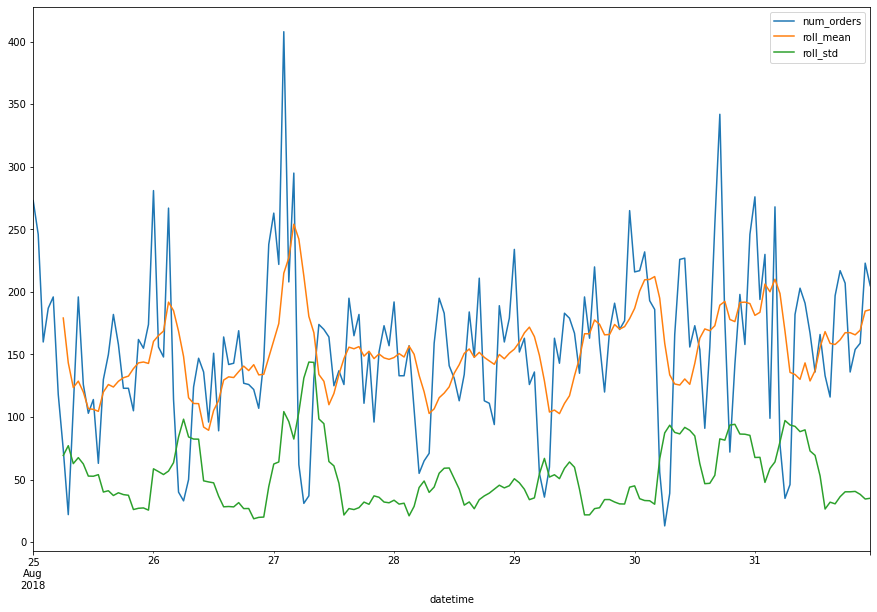

In [10]:
data_std_mean = data_hour.loc['2018-08-25':'2018-08-31',:]
data_std_mean['roll_mean'] = data_std_mean['num_orders'].rolling(7).mean()
data_std_mean['roll_std'] = data_std_mean['num_orders'].rolling(7).std()
data_std_mean.plot(figsize = (15, 10))

Monday has the highest mean and standard deviation

However, we would the analyze the trend for the day with the highest orders, which is Thursday the 30th

/tmp/ipykernel_101/3696502116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spec_day['roll_mean'] = data_std_mean['num_orders'].rolling(7).mean()
/tmp/ipykernel_101/3696502116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spec_day['roll_std'] = data_std_mean['num_orders'].rolling(7).std()


<AxesSubplot:xlabel='datetime'>

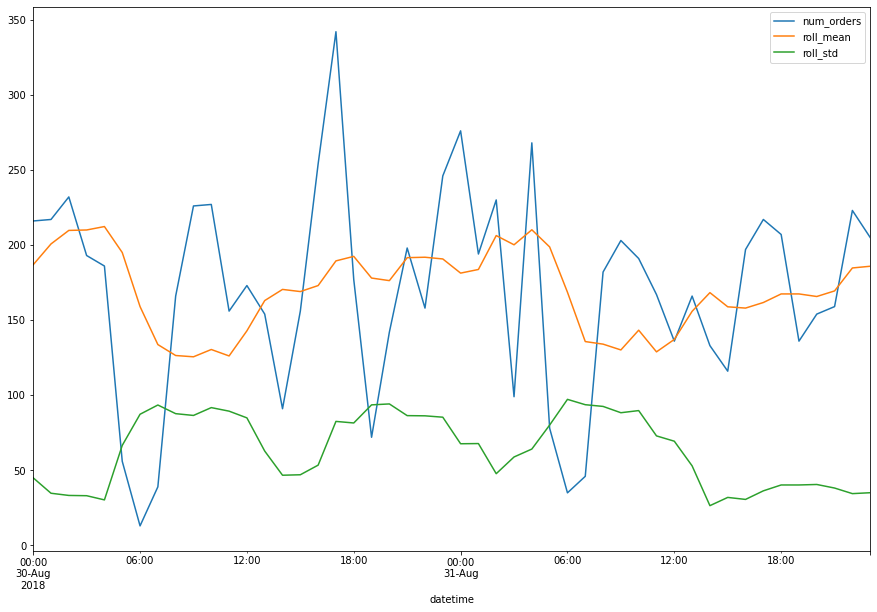

In [11]:
data_spec_day = data_hour.loc['2018-08-30':, :]
data_spec_day['roll_mean'] = data_std_mean['num_orders'].rolling(7).mean()
data_spec_day['roll_std'] = data_std_mean['num_orders'].rolling(7).std()
data_spec_day.plot(figsize = (15, 10))

## Training & Testing

We need to first of all create calendar features (month, day, dayofweek, hour), rolling mean, and lag features (7 of them) for our target, num_orders.

In [12]:
def make_features(data, max_lag, roll_mean_size):
    #creates a function called make_features which takes the data, max_lag and rolling window size as arguments
    data['month'] = data.index.month#creates month column
    data['day'] = data.index.day#creates day column
    data['dayofweek'] = data.index.dayofweek#creates dayofweek column
    data['hour'] = data.index.hour#creates hour column
    
    #creates the lag features for our target
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['roll_mean'] = data['num_orders'].shift().rolling(roll_mean_size).mean()#creates the rolling mean feature

make_features(data_hour, 6, 20)#runs our function on our hourly data, with 6 lag features and a rolling window of 20

data_hour.dropna(inplace=True)#drops the missing values
data_hour.head()#first 5 rows

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,roll_mean
datetime,,,,,,,,,,,,
2018-03-01 20:00:00,61,3,1,3,20,45.0,73.0,44.0,43.0,66.0,48.0,53.30
2018-03-01 21:00:00,66,3,1,3,21,61.0,45.0,73.0,44.0,43.0,66.0,50.15
2018-03-01 22:00:00,113,3,1,3,22,66.0,61.0,45.0,73.0,44.0,43.0,49.20
2018-03-01 23:00:00,58,3,1,3,23,113.0,66.0,61.0,45.0,73.0,44.0,51.30
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,50.90


We proceed to create our features and targets

In [13]:
features = data_hour.drop(['num_orders'], axis=1)#features
target = data_hour['num_orders']#targets

Let us split the data. We need to prevent shuffling by setting 'shuffle=False' and not putting any random_state since we are predicting according to the progression of time

In [14]:
feat_train, feat_test, targ_train, targ_test = train_test_split(features, target, shuffle = False, test_size = 0.1)
#splits the data, preventing shuffling

#print shapes of splits
print(feat_train.shape)
print(targ_train.shape)
print(feat_test.shape)
print(targ_test.shape)

(3956, 11)
(3956,)
(440, 11)
(440,)


We will create a separate set which will have one-hot encoding for the month, day, dayofweek, and hour features. However, this data will not be used for the tree models.

In [15]:
data_hour_ohe = pd.get_dummies(data = data_hour, columns=['month', 'day', 'dayofweek', 'hour'], drop_first = True )
#gets dummy columns for the 'month', 'day', 'dayofweek', 'hour' columns

feat_ohe = data_hour_ohe.drop('num_orders', axis = 1)
targ_ohe = data_hour_ohe['num_orders']

feat_train_ohe, feat_test_ohe, targ_train_ohe, targ_test_ohe = train_test_split(feat_ohe, targ_ohe, shuffle=False, test_size=0.1)
print(feat_train_ohe.shape)
print(targ_train_ohe.shape)
print(feat_test_ohe.shape)
print(targ_test_ohe.shape)

(3956, 71)
(3956,)
(440, 71)
(440,)


Let us create our RMSE function.

In [16]:
def rmse(targ, pred):
    
    targ = np.array(targ) #Convert the target into an array
    pred = np.array(pred) #Converts the predictions into an array
    error = (pred - targ) ** 2 #gets the
    msq_error = error.mean() #gets the mean
    score = msq_error**0.5 #gets the square root of the mean
    return score

scorer = make_scorer(rmse, greater_is_better = False) #makes our function an evaluation metric, lower values are better



## Linear Regression

We will do some cross-validation

#LR cross-validation

LR = LinearRegression()
LR_score = cross_val_score(LR, feat_train, targ_train, scoring = scorer, cv =3) 
#calculates the cross-validation scores for 3 folds of the training data
print(LR_score.mean()) #prints the mean of those scores

Now we can train, and test, to get the RMSE

In [17]:
LR = LinearRegression()
LR.fit(feat_train, targ_train)
LR_pred = LR.predict(feat_test)
LR_rmse = rmse(targ_test, LR_pred)
LR_rmse

55.6712135398457

We create our Linear Regression model on the encoded sets

In [18]:
LR_ohe = LinearRegression()
LR_ohe.fit(feat_train_ohe, targ_train_ohe)
LR_ohe_pred = LR_ohe.predict(feat_test_ohe)
LR_ohe_rmse = rmse(targ_test_ohe, LR_ohe_pred)
LR_ohe_rmse

45.72646812841216

One hot encoding improved the quality of the Linear Regression Model

The RMSE score of the Linear Regression Model is 56.67. However, the RMSE of the encoded Linear Regression model is 45.7. This is baseline score that all other models must exceed.

## Decision Tree

We will perform hyperparameter tuning (with max_depth hyperparameter) and get cross_validation scores. We will train the model with the hyperparameter which yields the best score

In [19]:
#DTR hyperparameter tuning with max depth to get cross_validation scores
tscv = TimeSeriesSplit()

for depth in range(3, 20):
    DTR = DecisionTreeRegressor(max_depth = depth, random_state=random_state)
    DTR_score = cross_val_score(DTR, feat_train, targ_train, scoring = scorer, cv=tscv)
    print('Max depth=', depth, ':', DTR_score.mean())

Max depth= 3 : -32.49706567917431
Max depth= 4 : -31.687038929384023
Max depth= 5 : -30.479578302737202
Max depth= 6 : -29.234481723928127
Max depth= 7 : -29.808741536478266
Max depth= 8 : -30.41792761765138
Max depth= 9 : -31.107269351438465
Max depth= 10 : -31.46678109294121
Max depth= 11 : -31.026825076730553
Max depth= 12 : -31.504589663553254
Max depth= 13 : -32.639907817060035
Max depth= 14 : -32.12490043956111
Max depth= 15 : -33.05949268342629
Max depth= 16 : -33.13804563381295
Max depth= 17 : -33.48557809955888
Max depth= 18 : -32.60663636177516
Max depth= 19 : -32.97510162615098


Now we can train and test, then get the RMSE

In [20]:
dtr = DecisionTreeRegressor(max_depth = 6, random_state = random_state)
dtr.fit(feat_train, targ_train)
dtr_pred = dtr.predict(feat_test)
dtr_rmse=rmse(targ_test, dtr_pred)
dtr_rmse

58.55182193338049

The RMSE of the Decision Tree Model is 58.55, which is worse than our baseline Linear Regression Model

## Random Forest

For this modelling, we would be calling the RandomForestRegressor() function. The hyperparameters that we will be dealing with are max_depth, which is the depth of each tree, and n_estimators, which is the number of trees.

In [21]:
#Random Forest Regressor - hyperparameter tuning
tcsv = TimeSeriesSplit() 

for depth in range(1, 20):
    RFR = RandomForestRegressor(n_estimators = 30, max_depth = depth, random_state = random_state)
    RFR_score = cross_val_score(RFR, feat_train, targ_train, scoring = scorer, cv = tcsv)
    print('Max_depth', depth, 'score:', RFR_score.mean())

Max_depth 1 score: -35.8733191824161
Max_depth 2 score: -33.63522581840331
Max_depth 3 score: -31.675726533026523
Max_depth 4 score: -30.521756971145834
Max_depth 5 score: -29.14950581701073
Max_depth 6 score: -27.95255165539216
Max_depth 7 score: -26.943455241440482
Max_depth 8 score: -26.339673249962722
Max_depth 9 score: -26.030618533400713
Max_depth 10 score: -25.870423876291728
Max_depth 11 score: -25.714918688791478
Max_depth 12 score: -25.659841728563215
Max_depth 13 score: -25.646663836684922
Max_depth 14 score: -25.60402449096369
Max_depth 15 score: -25.552629661670622
Max_depth 16 score: -25.555244640621336
Max_depth 17 score: -25.583074240974103
Max_depth 18 score: -25.628056347294585
Max_depth 19 score: -25.589441308974425


We can now train and test, then get the RMSE with these parameters

In [22]:
RFR = RandomForestRegressor(n_estimators= 40, max_depth = 15, random_state = random_state)
RFR.fit(feat_train, targ_train)
RFR_pred = RFR.predict(feat_test)
RFR_rmse = rmse(targ_test, RFR_pred)
RFR_rmse

44.448111984765575

The RMSE of the Random Forest Model is 44.44, which is much better than our baseline Linear Regression Model

## CatBoost Regressor

We will first do hyperparameter tuning with GridSearchCV to get the best parameters to train the model

In [23]:
#Modelling using CatBoost

tscv = TimeSeriesSplit()

CBR = CatBoostRegressor()
parameters = {'depth':[6, 8, 10],
            'learning_rate':[0.5, 0.1],
            'l2_leaf_reg':[2, 4],
            'iterations':[10, 50],
            'loss_function':['RMSE'],
            'random_seed':[random_state]}#parameters to search
grid = GridSearchCV(estimator = CBR, param_grid=parameters, scoring=scorer, cv = tscv, n_jobs=-1, verbose=0)
#Hyperparameter tuning
grid.fit(feat_train, targ_train)#fits the training data
best_param=grid.best_params_#gets the best parameters


0:	learn: 24.0441306	total: 47.9ms	remaining: 432ms
1:	learn: 21.0696841	total: 49.6ms	remaining: 199ms
2:	learn: 18.9110021	total: 51.3ms	remaining: 120ms
3:	learn: 18.2548955	total: 53ms	remaining: 79.6ms
4:	learn: 17.7003939	total: 54.9ms	remaining: 54.9ms
5:	learn: 16.9757361	total: 56.3ms	remaining: 37.5ms
6:	learn: 16.2421844	total: 57.7ms	remaining: 24.7ms
7:	learn: 15.8811667	total: 59.4ms	remaining: 14.9ms
8:	learn: 15.4829692	total: 60.7ms	remaining: 6.75ms
9:	learn: 14.9720739	total: 62.4ms	remaining: 0us
0:	learn: 24.7050837	total: 1.97ms	remaining: 17.7ms
1:	learn: 22.2162457	total: 3.92ms	remaining: 15.7ms
2:	learn: 21.1359077	total: 5.85ms	remaining: 13.7ms
3:	learn: 19.8990168	total: 7.73ms	remaining: 11.6ms
4:	learn: 19.1144081	total: 9.33ms	remaining: 9.33ms
5:	learn: 18.4382495	total: 11ms	remaining: 7.36ms
6:	learn: 18.1112270	total: 12.6ms	remaining: 5.42ms
7:	learn: 17.6883108	total: 14.6ms	remaining: 3.64ms
8:	learn: 17.1991425	total: 16.1ms	remaining: 1.79ms
9:	

Getting the best parameters

In [24]:
print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: -26.15146911583716
Best parameters: {'depth': 6, 'iterations': 50, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'loss_function': 'RMSE', 'random_seed': 12345}


Next, we train our CatBoost Regressor model using the best hyperparameter settings.

In [25]:
#CatBoost Model training 

CBR_model = CatBoostRegressor(depth = 6,
                              iterations = 50,
                              l2_leaf_reg = 4,
                              learning_rate = 0.5,
                              loss_function = 'RMSE', 
                              random_seed = random_state)

CBR_model.fit(feat_train, targ_train, verbose = False, plot = False)
CBR_pred = CBR_model.predict(feat_test)
CBR_rmse = rmse(targ_test, CBR_pred)
CBR_rmse


43.979569147157164

The RMSE of the CatBoost Regressor Model is 43.97, which is much better than our baseline Linear Regression Model

## LGBM Regressor Model

First, we perform hyperparameter tuning:

In [26]:
#Modelling using LGBM

tscv = TimeSeriesSplit()

model_LGBM = LGBMRegressor()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['rmse'],
            'random_state':[random_state]}
grid = GridSearchCV(estimator = model_LGBM, param_grid = parameters, scoring=scorer, cv = tscv, 
                    n_jobs=-1, verbose=0)
grid.fit(feat_train, targ_train)
best_param = grid.best_params_

In [27]:
print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: -25.722527170765716
Best parameters: {'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 20, 'objective': 'rmse', 'random_state': 12345}


Next, we will train and test our LightGBM model using the hyperparameter settings above, while timing the process

In [28]:
#LightGBM model training

LGBM = LGBMRegressor(learning_rate = 0.5,
                           n_estimators = 10,
                           num_leaves = 20,
                           objective = 'rmse',
                           random_state = random_state)

LGBM.fit(feat_train, targ_train)
LGBM_pred = LGBM.predict(feat_test)
LGBM_rmse = rmse(targ_test, LGBM_pred)
LGBM_rmse

47.136895976379925

The RMSE of the LightGBM Regressor Model is 47.139, which is much better than our baseline Linear Regression Model

## Conclusion

We analyzed the Time series data and saw that the peak day for taxi trips was Thursdays. the 30th and the peak hours were between 6am and 3pm

In [30]:
summary = pd.DataFrame(index=['LR', 'LR_ohe_rmse', 'DTR', 'RFR', 'CBR', 'LGBM'],
                     data={'RMSE':[LR_rmse, LR_ohe_rmse, dtr_rmse, RFR_rmse, CBR_rmse,
                                   LGBM_rmse]})
summary

,RMSE
LR,55.671214
LR_ohe_rmse,45.726468
DTR,58.551822
RFR,44.448112
CBR,43.979569
LGBM,47.136896


From the table above, we see that the CatBoost Regressor model has the best root mean square error. So the CatBoost Regressor will be our recommended model